In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
!pip install -q tensorflow-text

In [5]:
!pip install -q tf-models-official

In [6]:
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

In [7]:
from tqdm.notebook import tqdm
import tensorflow as tf

In [8]:
import tensorflow_hub as hub

In [9]:
import tensorflow_text as text

In [10]:
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

In [11]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
print(tf.__version__)

2.4.0


In [12]:
import shutil
from official.nlp import optimization
tf.get_logger().setLevel('ERROR')

In [13]:
import os

In [14]:
os.getcwd()

'/Users/Diane/Documents/ML2021/Hatespeech/SentimentAnalysis/cnn'

In [15]:
PATH = '~/Documents/ML2021/Hatespeech/SentimentAnalysis/data/cleandata/cleaned.csv'
df = pd.read_csv(PATH)

In [16]:
df

,Unnamed: 0,text,category,label,data_type
0,0,mayasolovely woman complain cleaning house amp...,neither,2,test
1,1,mleew17 boy dat cold tyga dwn bad cuffin dat h...,offensive_lang,1,train
2,2,urkindofbrand dawg 80sbaby4life fuck bitch sta...,offensive_lang,1,train
3,3,c g anderson viva based look like tranny,offensive_lang,1,train
4,4,shenikaroberts shit hear true faker bitch told...,offensive_lang,1,train
...,...,...,...,...,...
24778,24778,muthaf lie 8220 lifeasking 20 pearl corey eman...,offensive_lang,1,train
24779,24779,gone broke wrong heart baby drove redneck crazy,neither,2,train
24780,24780,young buck wanna eat dat nigguh like aint fuck...,offensive_lang,1,train
24781,24781,youu got wild bitch tellin lie,offensive_lang,1,train


In [17]:
df.groupby(['category','label','data_type']).count()

Unnamed: 0   text
category       label data_type                   
hate_speech    0     test              143    143
                     train            1158   1158
                     val               129    129
neither        2     test              416    416
                     train            3372   3372
                     val               375    375
offensive_lang 1     test             1920   1920
                     train           15543  15543
                     val              1727   1727

In [18]:
df_train = df.loc[df["data_type"]=="train"]
df_train.head(5)

,Unnamed: 0,text,category,label,data_type
1,1,mleew17 boy dat cold tyga dwn bad cuffin dat h...,offensive_lang,1,train
2,2,urkindofbrand dawg 80sbaby4life fuck bitch sta...,offensive_lang,1,train
3,3,c g anderson viva based look like tranny,offensive_lang,1,train
4,4,shenikaroberts shit hear true faker bitch told...,offensive_lang,1,train
6,6,brighterdays sit hate bitch got shit going,offensive_lang,1,train


In [19]:
df_val = df.loc[df["data_type"]=="val"]
df_val.head(5)

,Unnamed: 0,text,category,label,data_type
5,5,madison x shit blow claim faithful somebody fu...,offensive_lang,1,val
27,27,met pussy ocean dr gave pussy pill 128524,offensive_lang,1,val
31,31,im old old bitch excited 128524,offensive_lang,1,val
44,44,post picture pussy 200 like,offensive_lang,1,val
46,46,quick piece pussy drive,offensive_lang,1,val


In [20]:
df_test = df.loc[df["data_type"]=="test"]
df_test.head(5)

,Unnamed: 0,text,category,label,data_type
0,0,mayasolovely woman complain cleaning house amp...,neither,2,test
12,12,hoe smoke loser yea ig,offensive_lang,1,test
14,14,bitch,offensive_lang,1,test
17,17,bitch love,offensive_lang,1,test
25,25,pussy lip like heaven door 128524,offensive_lang,1,test


In [21]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

In [22]:
train_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [23]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [24]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [25]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [26]:
for feat, targ in train_ds.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b'damn near flossing bitch tampon string awful 8220 taecocky stopped eating pussy 8221 '
 b'blasianbytch graceishuman rhiannonrevolts yellow face '
 b'playlist like smoke track nigga reggaeton bachata bitch slow jam lucky lady '
 b'ddebrinar smh hoe wait nayarivera ' b'fuck honeybun took bitch nigga '
 b'8 10 girl u went h look horrible wanna believe bout piss facebook hoe '
 b'sent idea voem wanna hold testing drill nice weather need run mock incident bad weather night '
 b'allegation u bedroom u word naive amp blind bitch know ur husband cheated u ramona dumb '
 b'caymarieee bitch coming said making plan '
 b'aaliyahhhm knowww righttt know use shit update status hoe '
 b'lmfao oh forgot texting u darealquitam vonshayeb told u text need buy salad bitch hungry '
 b'herfarm country teabaggers '
 b'littledebbie cloud cake twinkie http ooilml6m ' b'dom bitch boy '
 b'bitch brilliant haha http mhaiphrpbn '
 b'cuhcuhcuh blacc charcoal bitch sayin mixed irish false shit cuh '
 b'm

In [27]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}


In [28]:
map_model_to_preprocess = {
     'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

In [29]:
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [30]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

INFO:absl:Using /var/folders/s0/_q3xzymj09j_6vbcp8006r2r0000gn/T/tfhub_modules to cache modules.


In [31]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [tweet]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Tweet: b'woman feminist ugly bitch man '
Label : 0
Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2450 10469  9200  7743  2158   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [32]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [33]:
bert_results = bert_model(text_preprocessed)
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.97953606  0.99045545  0.37422335  0.08272121  0.3678527   0.94071305
  0.9956316  -0.99471915 -0.40644705 -0.9681446   0.28947935 -0.95132107]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.68648076  0.03341969  0.47314835 ... -1.198112    0.81355035
  -0.28685504]
 [-0.6257362   0.3436981  -0.12805979 ... -0.6546574  -0.04581443
   0.7823926 ]
 [-0.72064906  0.41813582  1.0333399  ... -0.43816686 -0.3524723
   0.44031236]
 ...
 [-0.5160312   0.31548324  0.23160839 ... -0.6369806   0.6174426
   0.05740657]
 [-0.31858593  0.36847255  0.06999425 ... -0.33840683  0.8754311
  -0.05891985]
 [-0.21503675  0.3197237  -0.11285803 ... -0.1055902   1.038223
  -0.12804005]]


In [34]:
hate, offensive, neither = np.bincount(df['label'])
total = hate + offensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, offensive, 100 * offensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

Examples:
    Total: 24783
    hate: 1430 (5.77% of total)

Examples:
    Total: 24783
    Ofensive: 19190 (77.43% of total)

Examples:
    Total: 24783
    Neither: 4163 (16.80% of total)



In [35]:
weight_for_0 = (1 / hate)*(total)/3.0 
weight_for_1 = (1 / offensive)*(total)/3.0
weight_for_2 = (1 / neither)*(total)/3.0


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 5.78
Weight for class 1: 0.43
Weight for class 2: 1.98


In [36]:
initial_output_bias = np.array([3.938462, 15, 5.])
initial_output_bias 

array([ 3.938462, 15.      ,  5.      ])

In [37]:
def build_CNN_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    #net = outputs['pooled_output'] # [batch_size, 768].
    net = sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 768]
      
    
    net = tf.keras.layers.Conv1D(32, (2), activation='relu')(net)
    #net = tf.keras.layers.MaxPooling1D(2)(net)
    
    net = tf.keras.layers.Conv1D(64, (2), activation='relu')(net)
    #net = tf.keras.layers.MaxPooling1D(2)(net)
    net = tf.keras.layers.GlobalMaxPool1D()(net)
    
#    net = tf.keras.layers.Flatten()(net)
    
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    
    net = tf.keras.layers.Dropout(0.1)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [38]:
cnn_classifier_model = build_CNN_classifier_model()
bert_raw_result = cnn_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.57201105 0.6200258  0.5548487 ]], shape=(1, 3), dtype=float32)


In [39]:
text_test

[b'woman feminist ugly bitch man ']

In [40]:
cnn_classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

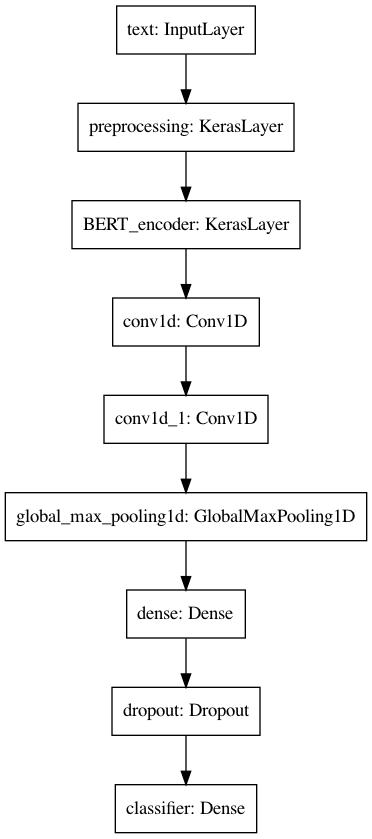

In [41]:
tf.keras.utils.plot_model(cnn_classifier_model)

In [42]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [43]:
epochs = 80
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

cnn_classifier_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
cnn_history = cnn_classifier_model.fit(x=train_ds,
                                       validation_data=val_ds,
                                       epochs=epochs,
                                       class_weight=class_weight
                                      )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/80
628/628 [==============================] - 4173s 7s/step - loss: 1.1517 - accuracy: 0.7353 - val_loss: 0.7964 - val_accuracy: 0.7965
Epoch 2/80
628/628 [==============================] - 4155s 7s/step - loss: 0.8971 - accuracy: 0.7746 - val_loss: 0.5177 - val_accuracy: 0.8418
Epoch 3/80
274/628 [============>.................] - ETA: 51:41 - loss: 0.6220 - accuracy: 0.8237